# Detekcija emocija

// todo: opisati projekat

## Preprocesiranje teksta
 
// blabla

In [1]:
import re
import io
import json
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer, tokenizer_from_json
from keras_preprocessing.sequence import pad_sequences
from textblob import TextBlob

In [2]:
def _correctTypos(text: str) -> str:
    blob = TextBlob(text).correct()
    return str(blob)
 
def _cleanLinks(text):
    """Cleans links and HTML tags from text."""
    pattern = re.compile(
        'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    clean = re.compile('<.*?>')
    text = re.sub(clean, '', text)
    text = re.sub(pattern, '', text)
    return text

def _cleanAbbreviations(text):
    text = re.sub(r"i['\s]?m\s", "i am ", text)
    text = re.sub(r"you're", "you are", text)
    text = re.sub(r"\su['\s]r\s", " you are ", text)
    text = re.sub(r"he['\s]?s\s", "he is ", text)
    text = re.sub(r"she['\s]?s", "she is", text)
    text = re.sub(r"that['\s]?s", "that is", text)
    text = re.sub(r"what['\s]?s", "what is", text)
    text = re.sub(r"where['\s]?s", "where is", text)
    text = re.sub(r"[\'\s]ll\s", " will ", text)
    text = re.sub(r"[\'\s]ll\s", " will ", text)
    text = re.sub(r"[\'\s]ve\s", " have ", text)
    text = re.sub(r"[\'\s]re\s", " are ", text)
    text = re.sub(r"[\'\s]d\s", " would ", text)
    text = re.sub(r"won['\s]?t", "will not", text)
    text = re.sub(r"don['\s]?t", "do not", text)
    text = re.sub(r"didn['\s]?t", "did not", text)
    text = re.sub(r"can['\s]?t", "can not", text)
    text = re.sub(r"couldn['\s]?t", "could not", text)
    text = re.sub(r"haven['\s]?t", "have not", text)
    text = re.sub(r"\sw(?:\s|$)", " with ", text)
    text = re.sub(r"\stbh\s", " to be honest ", text)
    #TODO: add more
    return text

def _removeSpecialChars(text):
    text = re.sub(r"[@#$%^&*(){}/;`~<>+=-]", "", text)
    return text

def _removeNumbers(text: str) -> str:
    return re.sub(r"\d+", '', text)

def _removePunctuation(text):
    tokens = word_tokenize(text)
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped if word.isalpha()]
    text = ' '.join(words)
    return text


def preprocess(inputData: dict, fns: list) -> tuple:
    inputData['sentiment'] = inputData['sentiment'].replace(
    {'joy': 0, 'anger': 1, 'love': 2, 'sadness': 3, 'fear': 4, 'surprise': 5})
    yinput = to_categorical(inputData['sentiment'].values)
    inputData['text'] = inputData['text'].map(lambda t: normalization(t, fns))
    xinput = inputData['text'].values
    return (xinput, yinput)

def makeTokenizer(xtrain: list):
    tokenizer = Tokenizer(15212, oov_token='UNK')
    tokenizer.fit_on_texts(xtrain)
    tokenizer_json = tokenizer.to_json()
    with io.open('preprocessing/tokenizer.json', 'w', encoding='utf-8') as f:
        f.write(json.dumps(tokenizer_json, ensure_ascii=False))
    return tokenizer
    
def textToSequences(text: list):
    tokenizer = None
    with open('preprocessing/tokenizer.json') as f:
        data = json.load(f)
        tokenizer = tokenizer_from_json(data)
        text = pad_sequences(tokenizer.texts_to_sequences(text), maxlen=80, padding='post')
        return text

### Stop words

In [3]:
stop_words = set(stopwords.words('english'))

def _removeStopWords(text: str) -> str:
    word_tokens = word_tokenize(text)
    filtered_text = [w for w in word_tokens if not w.lower() in stop_words]
    return " ".join(filtered_text)

### Lemmatization

In [4]:
lemmatizer = WordNetLemmatizer()

def _lemmatization(text: str) -> str:
    word_tokens = word_tokenize(text)
    text = [lemmatizer.lemmatize(y) for y in word_tokens]
    return " ".join(text)

### Normalization

In [5]:
def _normalizeText(text: str) -> str:
    text = _removeNumbers(text.lower())
    text = _removeStopWords(text)
    text = _cleanAbbreviations(_cleanLinks(text))
    text = _removeSpecialChars(text)
    text = _removePunctuation(text)
    text = _lemmatization(text)
    return text

In [6]:
def normalization(text: str, functions: list) -> str:
    for f in functions:
        text = f(text)
    return text

## Kreiranje modela

// blabla

In [7]:
import pandas as pd
import io
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

In [8]:
fns = [_removeNumbers, _removeStopWords, _cleanLinks, _cleanAbbreviations, _removeSpecialChars, _removePunctuation, _lemmatization]

def trainModel():
    train = pd.read_csv('train.txt', sep=';', names=['text', 'sentiment'])
    test = pd.read_csv('test.txt', sep=';', names=['text', 'sentiment'])
    val = pd.read_csv('val.txt', sep=';', names=['text', 'sentiment'])
    _saveClassDistribution(train)

    xtrain, ytrain = preprocess(train, fns)
    xtest, ytest = preprocess(test, fns)
    xval, yval = preprocess(val, fns)

    # WORD EMBEDDING
    
    makeTokenizer(xtrain)
    xtrain = textToSequences(xtrain)
    xtest = textToSequences(xtest)
    xval = textToSequences(xval)

    model = _makeModel()
    hist = model.fit(xtrain, ytrain, epochs=15, validation_data=(xval, yval))
    model.save('model\emotions.h5')
    print("Model saved on disk.")

    _testModel(model, xtest, ytest)
    _saveFigures(hist)
    plot_model(model=model, to_file='model\model.png', show_layer_names=False, show_shapes=True, show_layer_activations=True)

    return model

def _makeModel():
    model = Sequential()
    model.add(Embedding(input_dim=15212, output_dim=64, input_length=80))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(6, activation="softmax"))
    model.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print(model.summary())
    return model

def _testModel(model, xtest, ytest):
    print("Testing the model...")
    print("The result obtained is:\n")
    test = pd.read_csv('test.txt', sep=';', names=['text', 'sentiment'])
    xtest, ytest = preprocess(test, fns)
    xtest = textToSequences(xtest)
    model.evaluate(xtest, ytest)


    yprediction = model.predict(xtest)
    yprediction = np.argmax(yprediction, axis=1)
    ytest = np.argmax(ytest, axis=1)
    result = confusion_matrix(ytest, yprediction, normalize='pred')
    print(result)

    classes = ["joy", "anger", "love", "sadness", "fear", "surprise"]
    df_cfm = pd.DataFrame(result, index = classes, columns = classes)
    plt.figure(figsize = (10,7))
    cfm_plot = sn.heatmap(df_cfm, annot=True)
    cfm_plot.figure.savefig("evaluation\cfm.png")
    print("\nConfusion matrix saved on disk.\n")

    getClassificationReport(model)


def getClassificationReport(model):
    test = pd.read_csv('test.txt', sep=';', names=['text', 'sentiment'])
    xtest, ytest = preprocess(test, fns)
    xtest = textToSequences(xtest)
    yprediction = model.predict(xtest)
    yprediction = np.argmax(yprediction, axis=1)
    ytest = np.argmax(ytest, axis=1)
    report = classification_report(ytest, yprediction)
    print(report)
    with io.open('evaluation/classificationreport.txt', 'w', encoding='utf-8') as f:
        f.write(report)


def _saveFigures(hist):
    plt.figure(figsize=(15, 10))
    plt.plot(hist.history['accuracy'], c='b', label='train')
    plt.plot(hist.history['val_accuracy'], c='r', label='validation')
    plt.title("Model Accuracy vs Epochs")
    plt.xlabel("EPOCHS")
    plt.ylabel("ACCURACY")
    plt.legend(loc='lower right')
    plt.savefig('evaluation/accuracy.jpg')

    plt.figure(figsize=(15, 10))
    plt.plot(hist.history['loss'], c='orange', label='train')
    plt.plot(hist.history['val_loss'], c='g', label='validation')
    plt.title("Model Loss vs Epochs")
    plt.xlabel("EPOCHS")
    plt.ylabel("LOSS")
    plt.legend(loc='upper right')
    plt.savefig('evaluation\loss.jpg')

def _saveClassDistribution(dataset):
    plt.figure(figsize=(15, 10))
    pie = dataset.sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%')
    pie.figure.set_size_inches(15, 10)
    pie.figure.legend(loc='lower right')
    pie.figure.savefig("evaluation/classdistribution.jpg")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 64)            973568    
                                                                 
 dropout (Dropout)           (None, 80, 64)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 80, 128)          66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               3

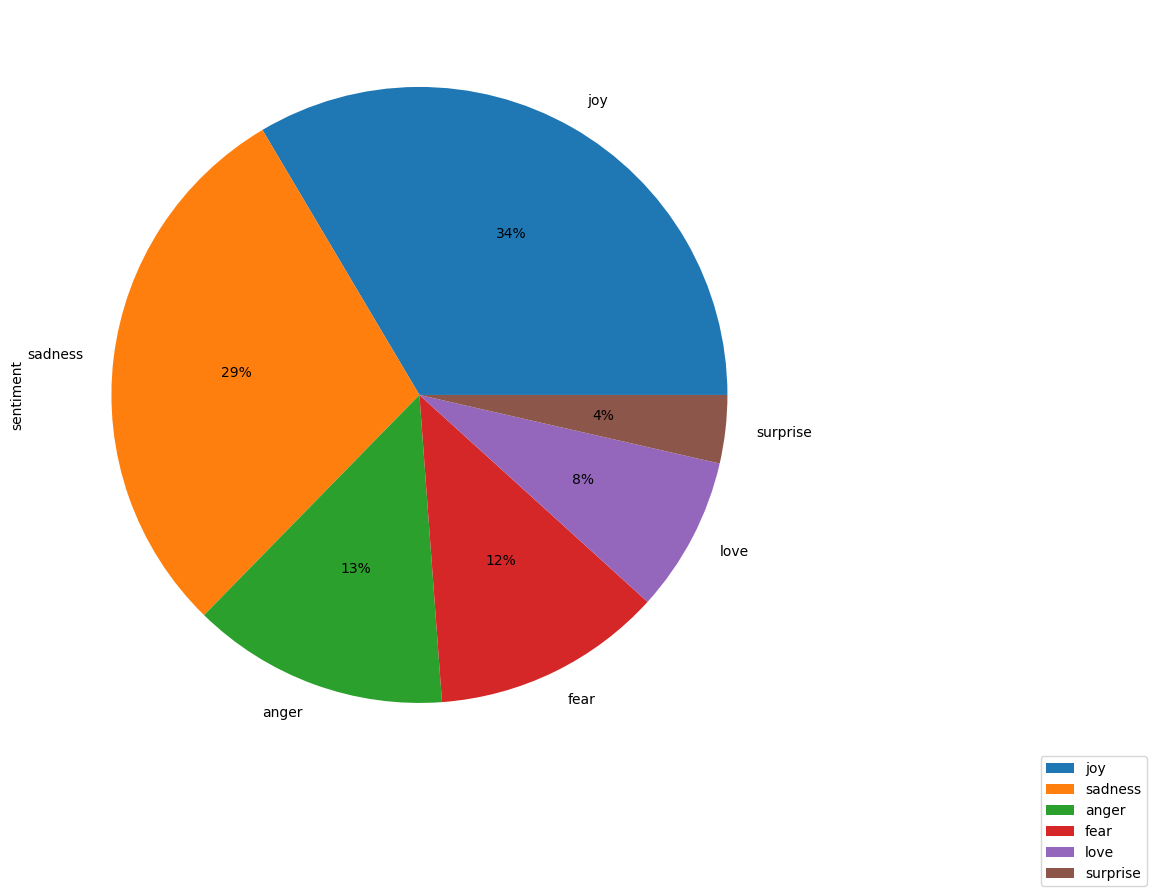

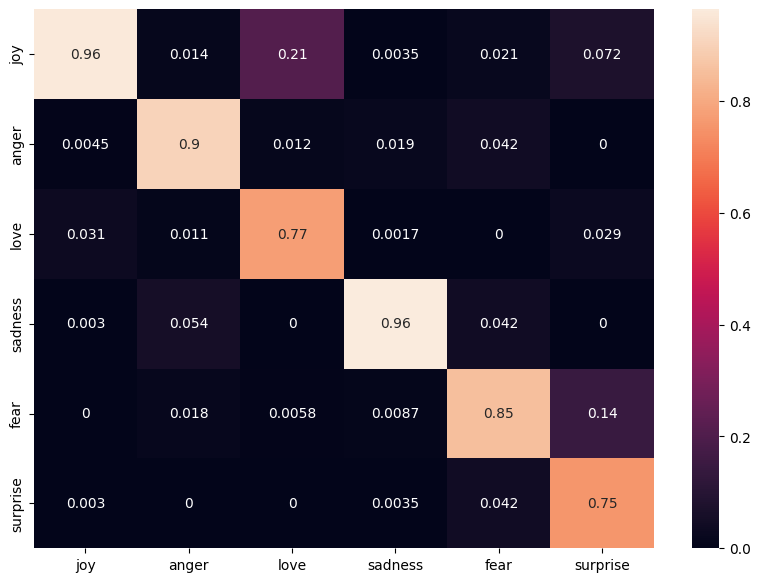

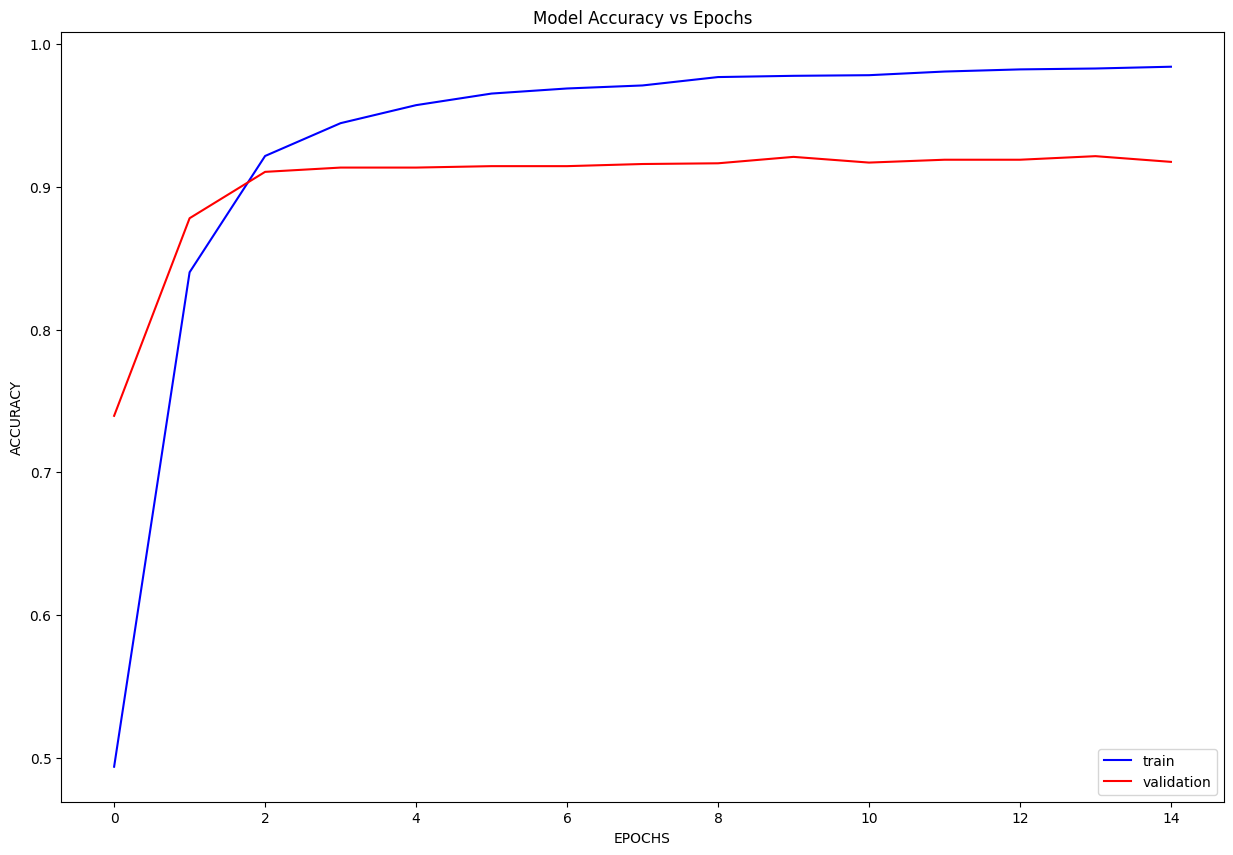

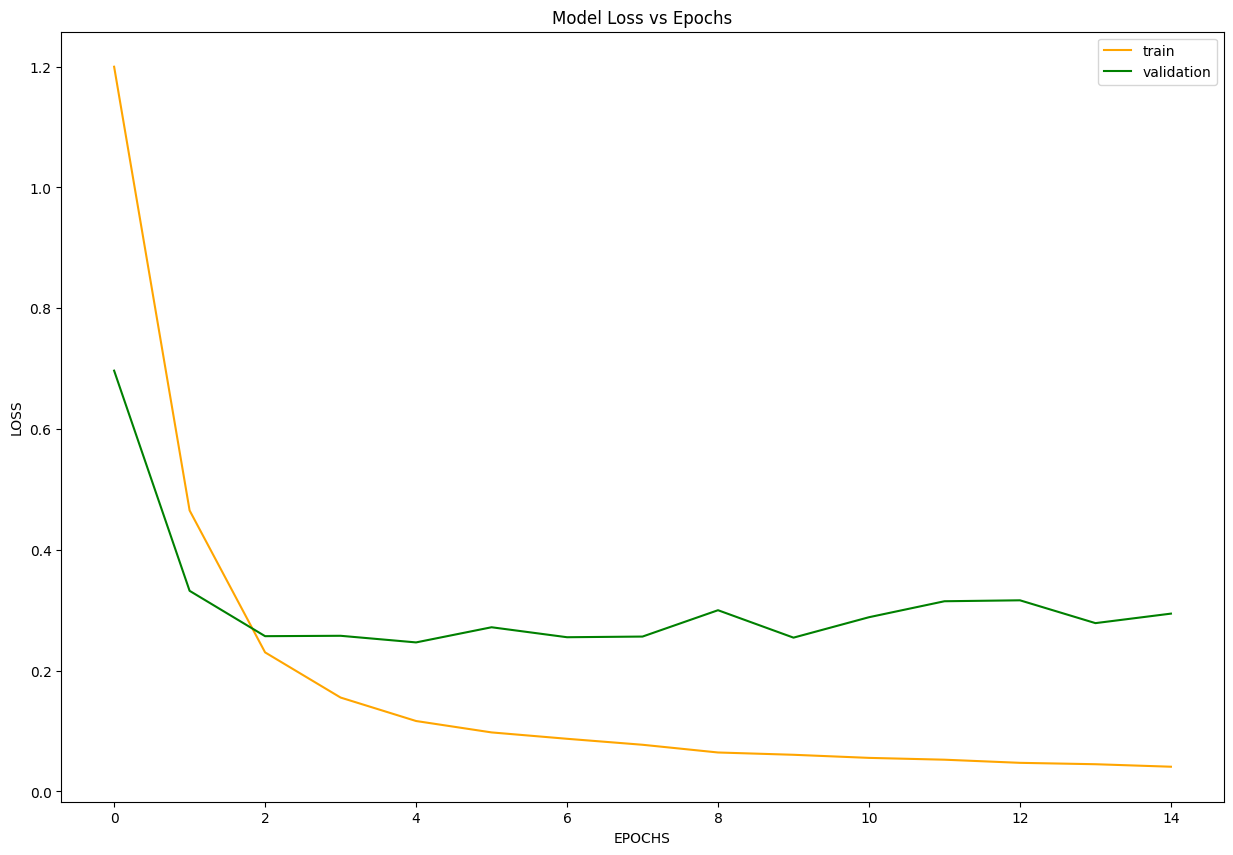

In [9]:
model = trainModel()   

## TF-IDF

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, 13536)            1         
 ectorization)                                                   
                                                                 
 reshape_2 (Reshape)         (None, 1, 13536)          0         
                                                                 
 dropout_4 (Dropout)         (None, 1, 13536)          0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 1, 128)           6963712   
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                      

INFO:tensorflow:Assets written to: model\emotions.tf\assets


INFO:tensorflow:Assets written to: model\emotions.tf\assets


Model saved on disk.
Testing the model...
The result obtained is:

63/63 [==============================] - 2s 6ms/step
[[0.75419664 0.00900901 0.19672131 0.05016722 0.04210526 0.05882353]
 [0.04316547 0.85135135 0.02459016 0.06187291 0.04736842 0.02941176]
 [0.06834532 0.01351351 0.70491803 0.01337793 0.02631579 0.        ]
 [0.08033573 0.06306306 0.04918033 0.80602007 0.04736842 0.08823529]
 [0.03477218 0.05405405 0.02459016 0.05183946 0.77894737 0.02941176]
 [0.01918465 0.00900901 0.         0.01672241 0.05789474 0.79411765]]

Confusion matrix saved on disk.

63/63 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.75      0.91      0.82       695
           1       0.85      0.69      0.76       275
           2       0.70      0.54      0.61       159
           3       0.81      0.83      0.82       581
           4       0.78      0.66      0.71       224
           5       0.79      0.41      0.54        66

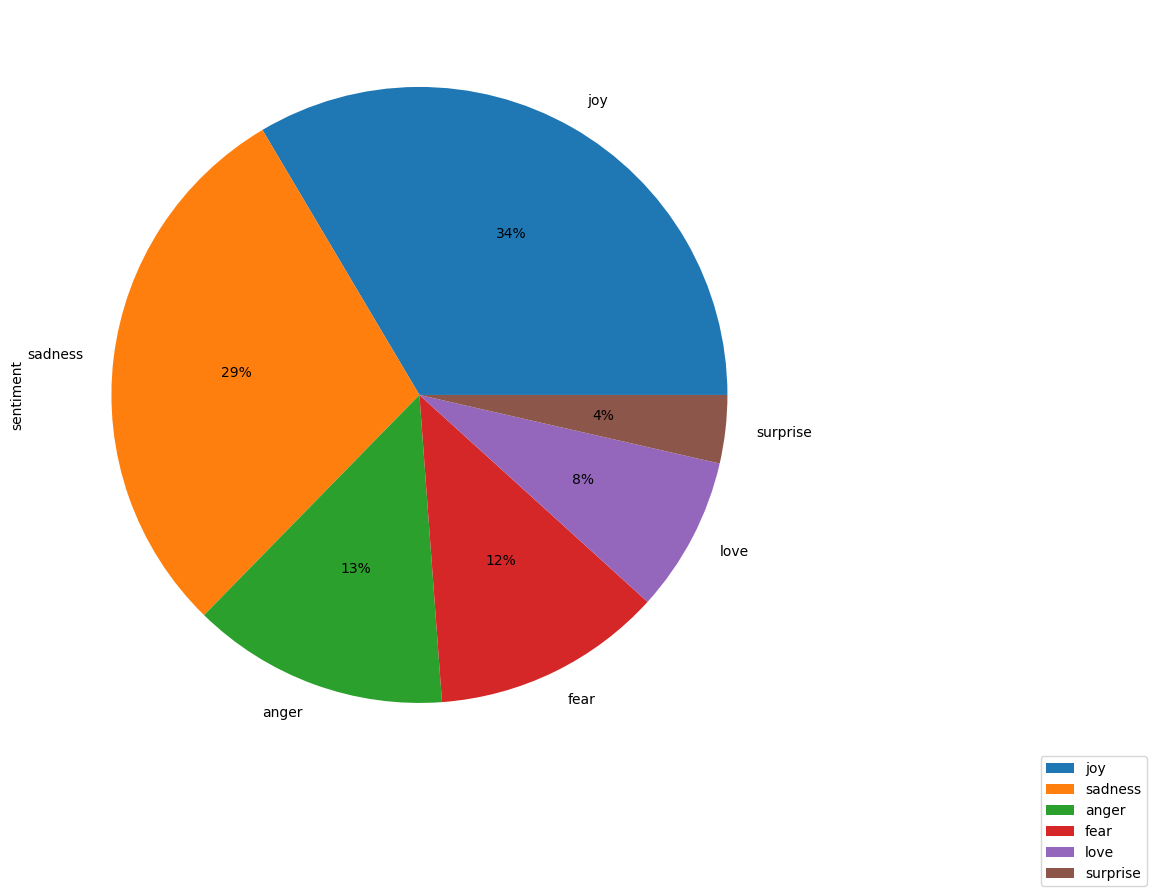

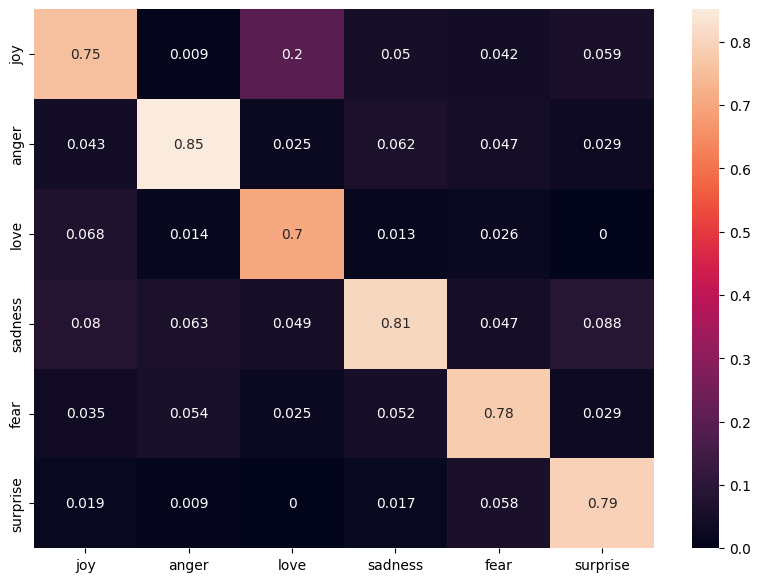

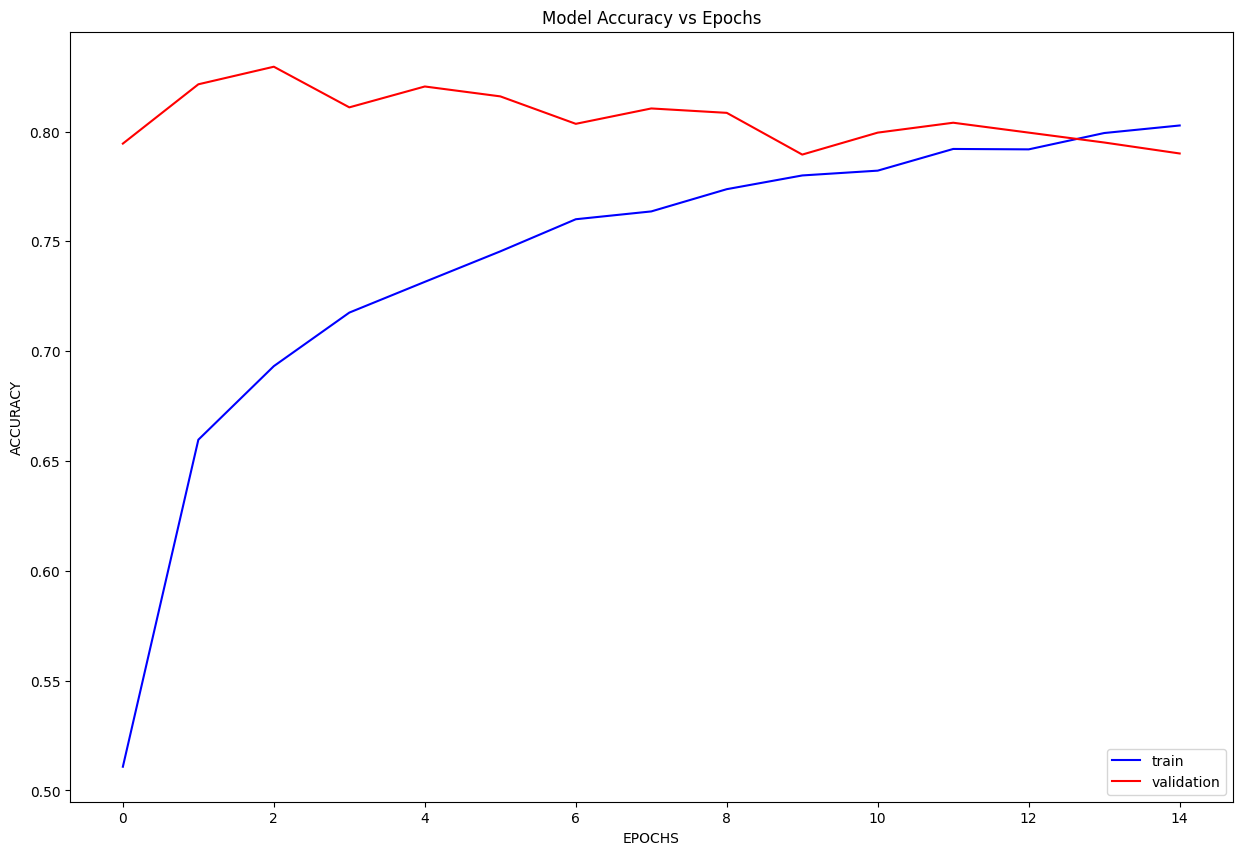

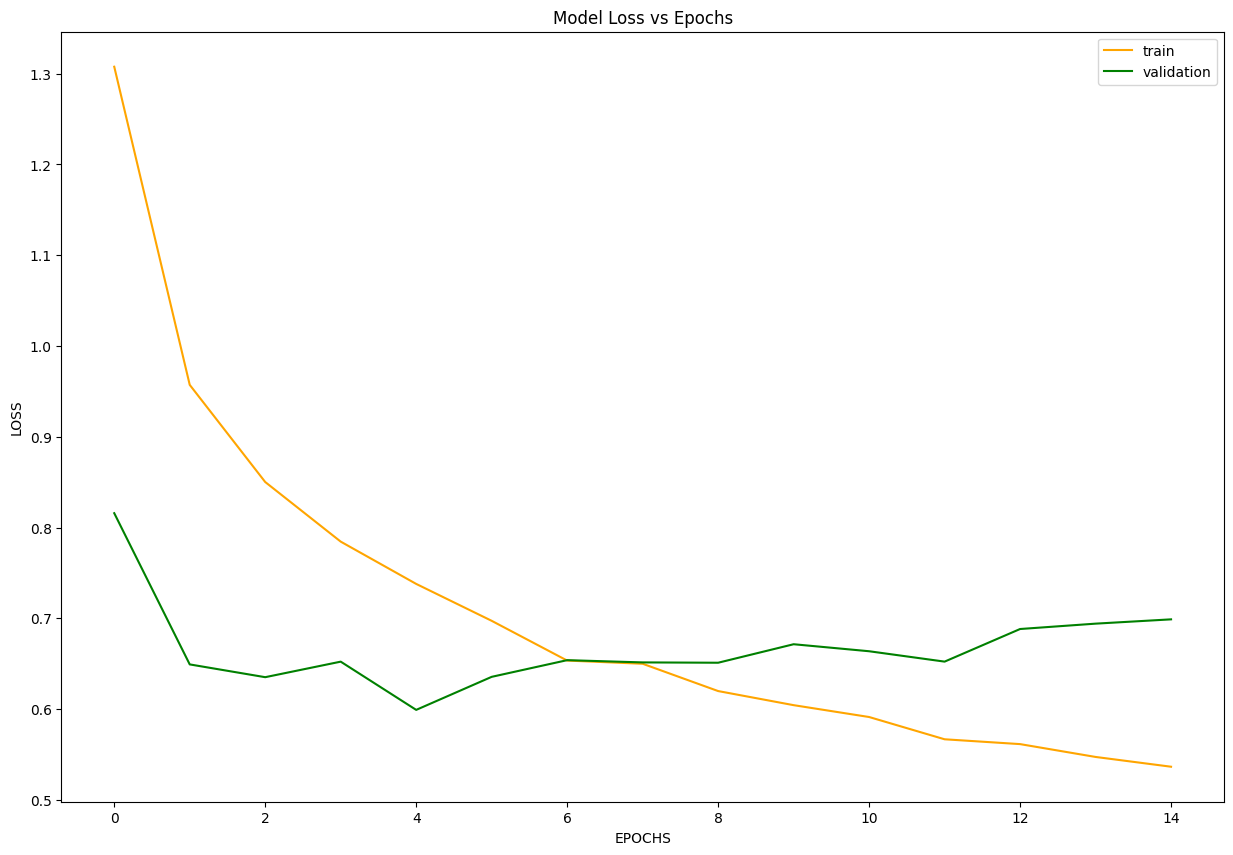

In [12]:
import tensorflow as tf
from keras.layers import TextVectorization

# TODO: text vectorization ne radi sa LSTM zbog output dimensions

def trainModel2():
    train = pd.read_csv('train.txt', sep=';', names=['text', 'sentiment'])
    test = pd.read_csv('test.txt', sep=';', names=['text', 'sentiment'])
    val = pd.read_csv('val.txt', sep=';', names=['text', 'sentiment'])
    _saveClassDistribution(train)

    xtrain, ytrain = preprocess(train, fns)
    xtest, ytest = preprocess(test, fns)
    xval, yval = preprocess(val, fns)

    # WORD EMBEDDING
    MAX_TOKENS_NUM = 15211  # Maximum vocab size.
    MAX_SEQUENCE_LEN = 80  # Sequence length to pad the outputs to.
    EMBEDDING_DIMS = 64

    vectorize_layer = TextVectorization(
    max_tokens=MAX_TOKENS_NUM,
    output_mode='tf-idf',
    #output_sequence_length=MAX_SEQUENCE_LEN
    )
    vectorize_layer.adapt(xtrain)

    model = _makeModel2(vectorize_layer)
    hist = model.fit(xtrain, ytrain, epochs=15, validation_data=(xval, yval))
    model.save('model\emotions.tf', save_format='tf')
    print("Model saved on disk.")

    _testModel2(model, xtest, ytest)
    _saveFigures(hist)
    plot_model(model=model, to_file='model\model.png', show_layer_names=False, show_shapes=True, show_layer_activations=True)

    return model

def _makeModel2(vectorize_layer):
    model = Sequential()

    model.add(tf.keras.Input(shape=(1, ), dtype=tf.string))
    model.add(vectorize_layer)
    model.add(tf.keras.layers.Reshape((1, 13536)))
    # model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.5))
    # model.add(Dense(64, activation="relu"))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(6, activation="softmax"))
    model.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print(model.summary())
    return model

def _testModel2(model, xtest, ytest):
    print("Testing the model...")
    print("The result obtained is:\n")
    test = pd.read_csv('test.txt', sep=';', names=['text', 'sentiment'])
    xtest, ytest = preprocess(test, fns)

    model.evaluate(xtest, ytest)


    yprediction = model.predict(xtest)
    yprediction = np.argmax(yprediction, axis=1)
    ytest = np.argmax(ytest, axis=1)
    result = confusion_matrix(ytest, yprediction, normalize='pred')
    print(result)

    classes = ["joy", "anger", "love", "sadness", "fear", "surprise"]
    df_cfm = pd.DataFrame(result, index = classes, columns = classes)
    plt.figure(figsize = (10,7))
    cfm_plot = sn.heatmap(df_cfm, annot=True)
    cfm_plot.figure.savefig("evaluation\cfm.png")
    print("\nConfusion matrix saved on disk.\n")

    getClassificationReport2(model)

def getClassificationReport2(model):
    test = pd.read_csv('test.txt', sep=';', names=['text', 'sentiment'])
    xtest, ytest = preprocess(test, fns)
    yprediction = model.predict(xtest)
    yprediction = np.argmax(yprediction, axis=1)
    ytest = np.argmax(ytest, axis=1)
    report = classification_report(ytest, yprediction)
    print(report)
    with io.open('evaluation/classificationreport.txt', 'w', encoding='utf-8') as f:
        f.write(report)

model2 = trainModel2()

## Word2Vec

In [31]:
import gensim
import gensim.downloader as api
from os import path
from gensim.models import Word2Vec

def trainModel3(epochs = 15):
    train = pd.read_csv('train.txt', sep=';', names=['text', 'sentiment'])
    test = pd.read_csv('test.txt', sep=';', names=['text', 'sentiment'])
    val = pd.read_csv('val.txt', sep=';', names=['text', 'sentiment'])
    _saveClassDistribution(train)

    xtrain, ytrain = preprocess(train, fns)
    xtest, ytest = preprocess(test, fns)
    xval, yval = preprocess(val, fns)

    # WORD EMBEDDING
    MAX_TOKENS_NUM = 15211  # Maximum vocab size.
    MAX_SEQUENCE_LEN = 80  # Sequence length to pad the outputs to.
    EMBEDDING_DIMS = 64

    Embedding_dimensions = 100

    Word2vec_train_data = list(map(lambda x: x.split(), xtrain))
    word2vec_model = Word2Vec(Word2vec_train_data,
                 vector_size=Embedding_dimensions,
                 workers=10,
                 min_count=5)
    print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))
    with open('preprocessing/tokenizer.json') as f:
        data = json.load(f)
        tokenizer = tokenizer_from_json(data)

    input_length = 80
    X_train = pad_sequences(tokenizer.texts_to_sequences(xtrain), maxlen=input_length)
    X_test  = pad_sequences(tokenizer.texts_to_sequences(xtest) , maxlen=input_length)
    X_val  = pad_sequences(tokenizer.texts_to_sequences(xval) , maxlen=input_length)

    print("X_train.shape:", X_train.shape)
    print("X_test.shape :", X_test.shape)

    embedding_matrix = np.zeros((MAX_TOKENS_NUM, Embedding_dimensions))

    for word, token in tokenizer.word_index.items():
        if word2vec_model.wv.__contains__(word):
            embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

    print("Embedding Matrix Shape:", embedding_matrix.shape)

    embedding_layer = Embedding(input_dim = MAX_TOKENS_NUM,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = _makeModel3(embedding_layer)
    hist = model.fit(X_train, ytrain, epochs=epochs, validation_data=(X_val, yval))
    model.save('model\emotions.tf', save_format='tf')
    print("Model saved on disk.")

    _testModel3(model, X_test, ytest)
    _saveFigures(hist)
    plot_model(model=model, to_file='model\model.png', show_layer_names=False, show_shapes=True, show_layer_activations=True)

    return model

def make_text_embedding(text: list, model):
    return

def _makeModel3(layer):
    model = Sequential()
    model.add(layer)
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(6, activation="softmax"))
    model.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print(model.summary())
    return model

def _testModel3(model, xtest, ytest):
    print("Testing the model...")
    print("The result obtained is:\n")
    model.evaluate(xtest, ytest)

    yprediction = model.predict(xtest)
    yprediction = np.argmax(yprediction, axis=1)
    ytest = np.argmax(ytest, axis=1)
    result = confusion_matrix(ytest, yprediction, normalize='pred')
    print(result)

    classes = ["joy", "anger", "love", "sadness", "fear", "surprise"]
    df_cfm = pd.DataFrame(result, index = classes, columns = classes)
    plt.figure(figsize = (10,7))
    cfm_plot = sn.heatmap(df_cfm, annot=True)
    cfm_plot.figure.savefig("evaluation\cfm.png")
    print("\nConfusion matrix saved on disk.\n")

    getClassificationReport3(yprediction, ytest)

def getClassificationReport3(yprediction, ytest):
    # yprediction = np.argmax(yprediction, axis=1)
    # ytest = np.argmax(ytest, axis=1)
    report = classification_report(ytest, yprediction)
    print(report)
    with io.open('evaluation/classificationreport.txt', 'w', encoding='utf-8') as f:
        f.write(report)

#model3 = trainModel3()

Vocabulary Length: 3217
X_train.shape: (16000, 80)
X_test.shape : (2000, 80)
Embedding Matrix Shape: (15211, 100)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 80, 100)           1521100   
                                                                 
 bidirectional_22 (Bidirecti  (None, 80, 200)          160800    
 onal)                                                           
                                                                 
 bidirectional_23 (Bidirecti  (None, 80, 200)          240800    
 onal)                                                           
                                                                 
 conv1d_2 (Conv1D)           (None, 76, 100)           100100    
                                                                 
 global_max_pooling1d_2 (Glo  (None, 100)              0         
 balM

INFO:tensorflow:Assets written to: model\emotions.tf\assets


INFO:tensorflow:Assets written to: model\emotions.tf\assets


Model saved on disk.
Testing the model...
The result obtained is:

63/63 [==============================] - 1s 7ms/step
[[0.45645331 0.25       0.42016807 0.22159888 0.24074074 0.14285714]
 [0.10073452 0.32       0.12605042 0.16129032 0.13888889 0.28571429]
 [0.11542497 0.01       0.12605042 0.04628331 0.         0.        ]
 [0.22035677 0.3        0.27731092 0.39270687 0.25       0.14285714]
 [0.07555089 0.08       0.04201681 0.14726508 0.28703704 0.42857143]
 [0.03147954 0.04       0.00840336 0.03085554 0.08333333 0.        ]]

Confusion matrix saved on disk.

              precision    recall  f1-score   support

           0       0.46      0.63      0.53       695
           1       0.32      0.12      0.17       275
           2       0.13      0.09      0.11       159
           3       0.39      0.48      0.43       581
           4       0.29      0.14      0.19       224
           5       0.00      0.00      0.00        66

    accuracy                           0.40      20

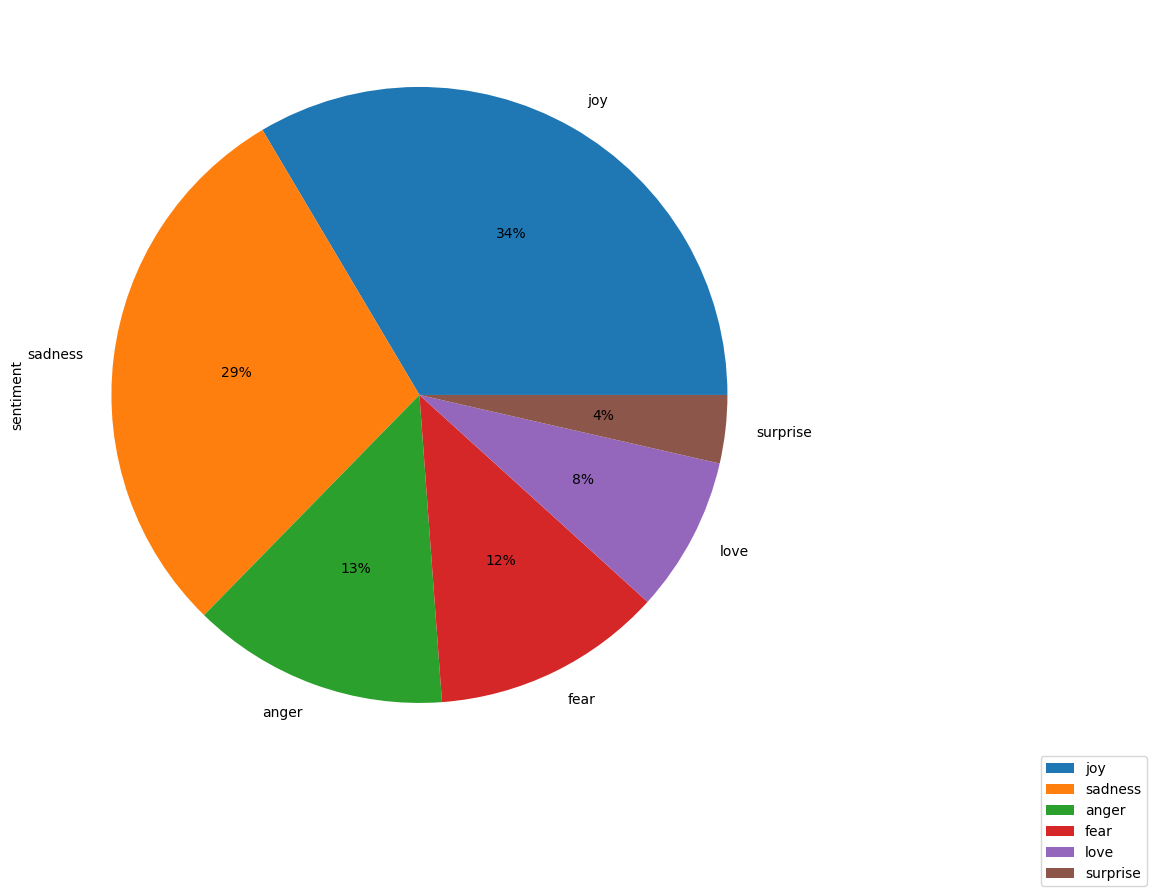

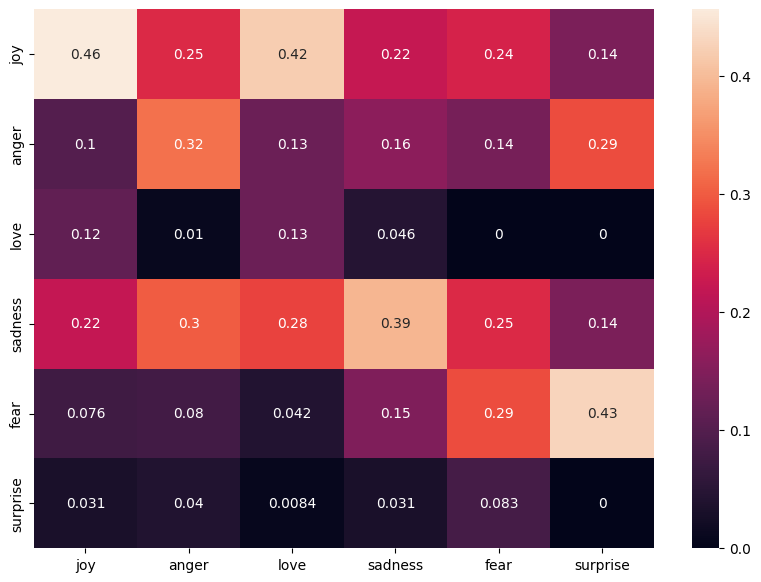

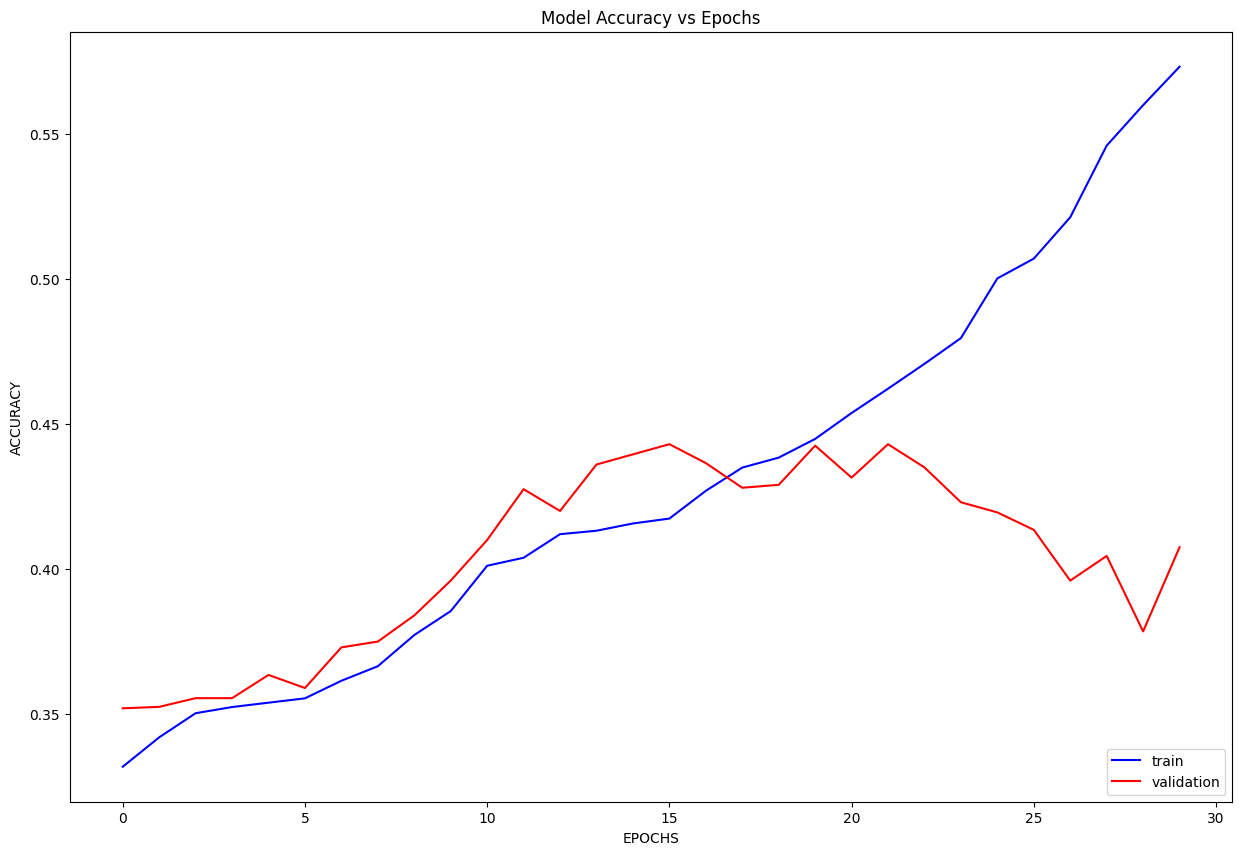

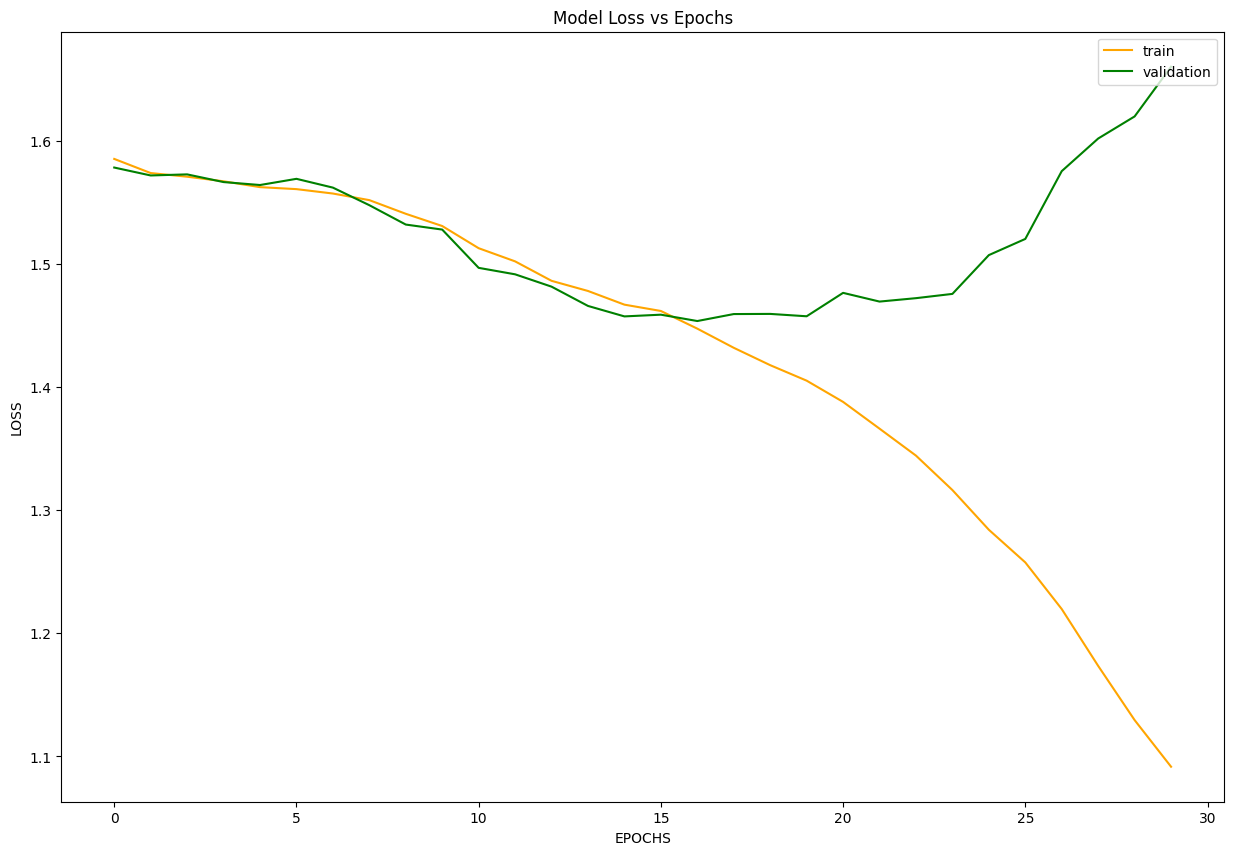

In [32]:
from tensorflow.keras.layers import GlobalMaxPool1D, Conv1D

def _makeModel3(layer):
    model = Sequential()
    model.add(layer)
    model.add(Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)))
    model.add(Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)))
    model.add(Conv1D(100, 5, activation='relu'))
    model.add(GlobalMaxPool1D())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(6, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print(model.summary())
    return model

model3 = trainModel3(30)